In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

Loading Dataset...


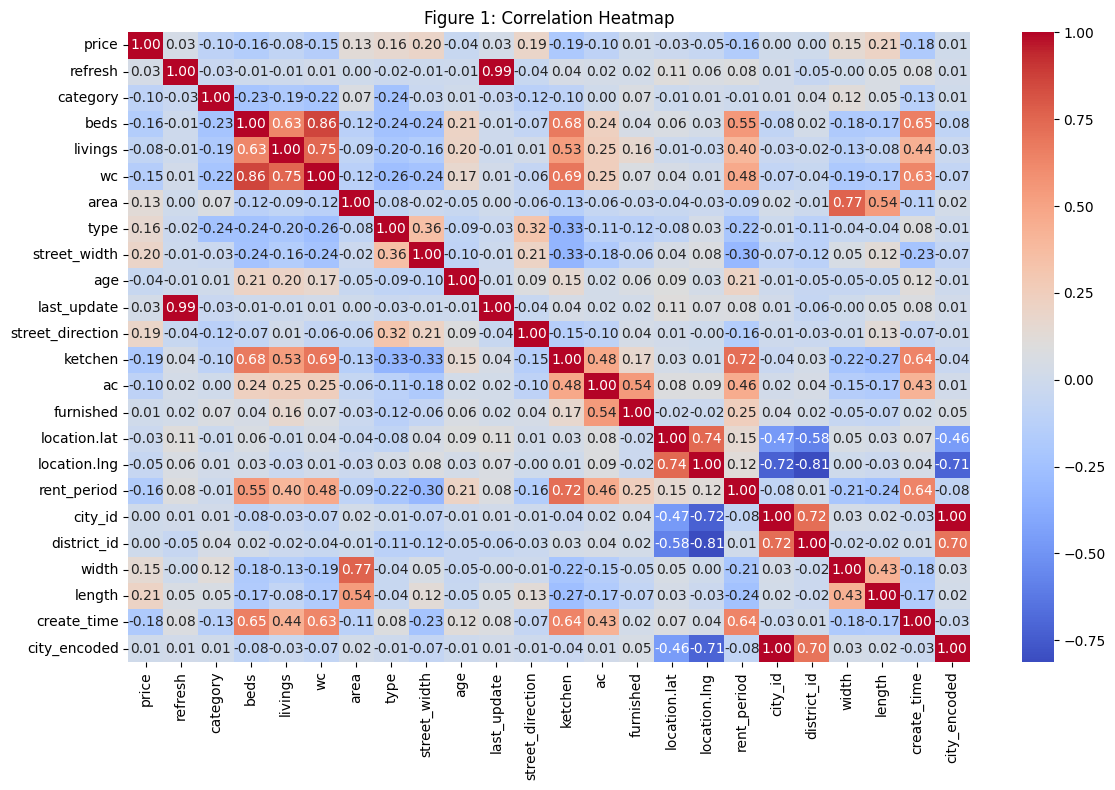

In [2]:
# ==========================================
# PHASE 1: Data Loading & Preprocessing (Tasks 1, 2, 3)
# ==========================================
print("Loading Dataset...")
# We use 'utf-8-sig' to correctly handle Arabic characters
df = pd.read_csv('Listings.csv', encoding="utf-8-sig", nrows=5000)

# Drop irrelevant columns (IDs, Images, URLs)
irrelevant_cols = [
    'user_id', 'id', 'native.logo', 'native.image', 'native.external_url', 
    'user.phone', 'native.description', 'user.review', 'user.iam_verified',
    'has_extended_details', 'daily_rentable', 'native.title'
]
df_clean = df.drop(columns=[c for c in irrelevant_cols if c in df.columns])

# Handle Missing Values
df_clean.dropna(subset=['price', 'area', 'beds', 'livings', 'wc', 'street_width'], inplace=True)

# Encode City
if 'city' in df_clean.columns:
    le = LabelEncoder()
    df_clean['city_encoded'] = le.fit_transform(df_clean['city'].astype(str))

# --- FIGURE 1: Correlation Heatmap (Task 2) ---
plt.figure(figsize=(12, 8))
sns.heatmap(df_clean.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Figure 1: Correlation Heatmap")
plt.tight_layout()
plt.show()



Performing Outlier Analysis...


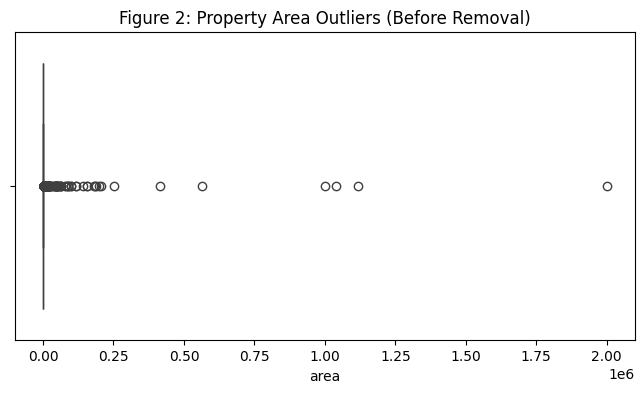

Data shape after outlier removal: (1652, 37)


In [3]:
# ==========================================
# PHASE 2: Outlier Analysis (Task 4)
# ==========================================
print("\nPerforming Outlier Analysis...")

# --- FIGURE 2: Boxplot Before Removal ---
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_clean['area'])
plt.title("Figure 2: Property Area Outliers (Before Removal)")
plt.show()

# Remove Outliers using IQR
Q1 = df_clean['area'].quantile(0.25)
Q3 = df_clean['area'].quantile(0.75)
IQR = Q3 - Q1
df_final = df_clean[(df_clean['area'] >= (Q1 - 1.5 * IQR)) & (df_clean['area'] <= (Q3 + 1.5 * IQR))].copy()
print(f"Data shape after outlier removal: {df_final.shape}")

In [4]:
# ==========================================
# PHASE 3: Modeling Setup (Task 5)
# ==========================================
# Create Target: 1 if Price > Median, else 0
median_price = df_final['price'].median()
df_final['Price_Category'] = df_final['price'].apply(lambda x: 1 if x > median_price else 0)

features = ['area', 'beds', 'livings', 'wc', 'street_width']
if 'city_encoded' in df_final.columns:
    features.append('city_encoded')

X = df_final[features]
y = df_final['Price_Category']

# Split and Scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# ==========================================
# PHASE 4: Training & Tuning (Task 5)
# ==========================================
print("\nTraining Models...")

# 1. Logistic Regression
lr = LogisticRegression()
grid_lr = GridSearchCV(lr, {'C': [0.1, 1, 10], 'solver': ['liblinear']}, cv=5)
grid_lr.fit(X_train_scaled, y_train)
y_pred_lr = grid_lr.predict(X_test_scaled)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")

# 2. Decision Tree
dt = DecisionTreeClassifier()
grid_dt = GridSearchCV(dt, {'max_depth': [3, 5, 10, None], 'criterion': ['entropy']}, cv=5)
grid_dt.fit(X_train, y_train)
y_pred_dt = grid_dt.predict(X_test)
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")

# 3. Random Forest (Best Model)
rf = RandomForestClassifier()
grid_rf = GridSearchCV(rf, {'n_estimators': [50, 100], 'max_depth': [10, 20]}, cv=5)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")


Training Models...
Logistic Regression Accuracy: 0.8006
Decision Tree Accuracy: 0.8399
Random Forest Accuracy: 0.8912


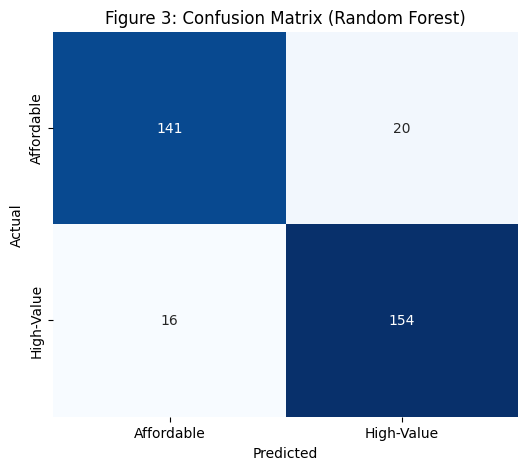

C:\Users\Ayman\AppData\Local\Temp\ipykernel_16908\4041361867.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette='viridis')


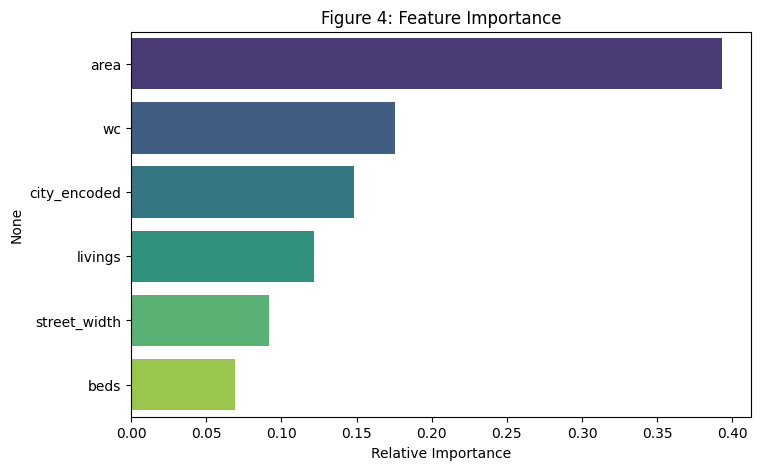

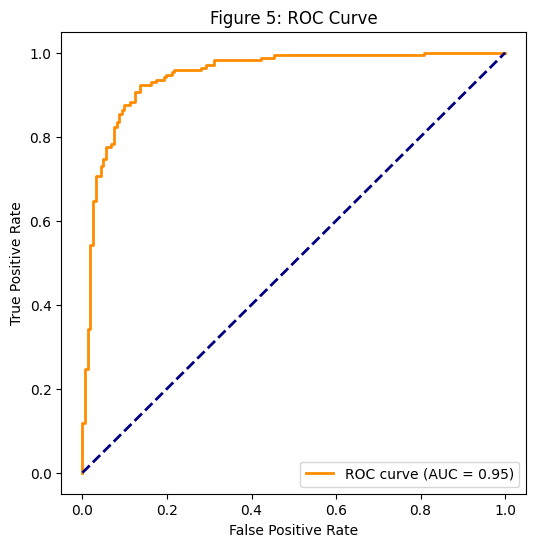


--- Final Report: Random Forest ---
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       161
           1       0.89      0.91      0.90       170

    accuracy                           0.89       331
   macro avg       0.89      0.89      0.89       331
weighted avg       0.89      0.89      0.89       331



In [6]:
# ==========================================
# PHASE 5: Advanced Visuals (Task 6)
# ==========================================

# --- FIGURE 3: Confusion Matrix ---
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Affordable', 'High-Value'],
            yticklabels=['Affordable', 'High-Value'])
plt.title('Figure 3: Confusion Matrix (Random Forest)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- FIGURE 4: Feature Importance ---
plt.figure(figsize=(8, 5))
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns
sns.barplot(x=importances[indices], y=feature_names[indices], palette='viridis')
plt.title('Figure 4: Feature Importance')
plt.xlabel('Relative Importance')
plt.show()

# --- FIGURE 5: ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 5: ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("\n--- Final Report: Random Forest ---")
print(classification_report(y_test, y_pred_rf))